In [164]:
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import util
from scipy.fft import fft, ifft, fftfreq, rfft
import pickle
from obspy import UTCDateTime
import scipy.signal as signal

In [2]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'

In [3]:
eq_list = os.listdir(root)

client = Client("IRIS")

cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])

In [146]:
cat_with_data[0:2]

2 Event(s) in Catalog:
2019-01-31T19:49:49.660000Z | -20.486,  -69.016 | 4.2 mb
2019-01-31T13:09:53.370000Z |  +8.978,  -83.758 | 4.9 Mwr

In [245]:
eq_name = eq_with_data[0]
data = obspy.read(root+eq_name+'/data/*/*')
data.plot()
inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
data.remove_response(inv)
# data.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

9 Trace(s) in Stream:
CX.HMBCX..HHE | 2019-01-31T19:44:44.679999Z - 2019-01-31T19:54:50.669999Z | 100.0 Hz, 60600 samples
CX.HMBCX..HHN | 2019-01-31T19:44:45.679999Z - 2019-01-31T19:54:52.669999Z | 100.0 Hz, 60700 samples
CX.HMBCX..HHZ | 2019-01-31T19:44:48.679999Z - 2019-01-31T19:54:51.669999Z | 100.0 Hz, 60300 samples
CX.PB01..HHE  | 2019-01-31T19:44:45.158393Z - 2019-01-31T19:54:55.628393Z | 100.0 Hz, 61048 samples
CX.PB01..HHN  | 2019-01-31T19:44:43.958393Z - 2019-01-31T19:54:50.028393Z | 100.0 Hz, 60608 samples
CX.PB01..HHZ  | 2019-01-31T19:44:46.698393Z - 2019-01-31T19:54:54.388393Z | 100.0 Hz, 60770 samples
CX.PB08..HHE  | 2019-01-31T19:44:46.698393Z - 2019-01-31T19:54:54.838393Z | 100.0 Hz, 60815 samples
CX.PB08..HHN  | 2019-01-31T19:44:47.448394Z - 2019-01-31T19:54:55.748394Z | 100.0 Hz, 60831 samples
CX.PB08..HHZ  | 2019-01-31T19:44:44.298393Z - 2019-01-31T19:54:50.558393Z | 100.0 Hz, 60627 samples

In [246]:
inv

Inventory created at 2021-10-28T15:56:51.413805Z
	Sending institution: SeisComP (GFZ)
	Contains:
		Networks (3):
			CX (3x)
		Stations (3):
			CX.HMBCX (IPOC Station Humberstone, Chile)
			CX.PB01 (IPOC Station Huatacondo, Chile)
			CX.PB08 (IPOC Station Macaya, Chile)
		Channels (9):
			CX.HMBCX..HHZ, CX.HMBCX..HHN, CX.HMBCX..HHE, CX.PB01..HHZ, 
			CX.PB01..HHN, CX.PB01..HHE, CX.PB08..HHZ, CX.PB08..HHN, 
			CX.PB08..HHE

In [247]:
with open(root+eq_name+'/picks.pkl', 'rb') as f:
    picks = pickle.load(f)
sr = data[0].stats.sampling_rate
tr_name = data[0].stats.network+'.'+data[0].stats.station+'.'+data[0].stats.location
pick = UTCDateTime(picks[tr_name])
start = int((pick - data[0].stats.starttime)*sr)
end = int(start + 4 * sr)
s = data[0].copy()#.filter('lowpass', freq=3)


detrend

In [248]:
coda = signal.detrend(s)
coda = s[start:end+1000]

taper and pad with zeros

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

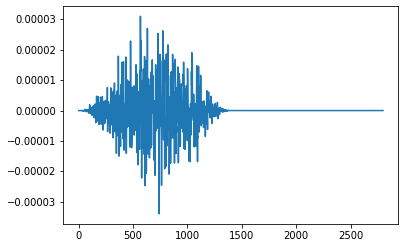

In [249]:
nx      = len(coda)
hann    = np.hanning(nx) #Is this the right sort of filter?
nx2     = 2*nx
x       = np.zeros(nx2)

x[0:nx] = coda*hann
plt.plot(x)

smooth

In [250]:
s.stats

         network: CX
         station: HMBCX
        location: 
         channel: HHE
       starttime: 2019-01-31T19:44:44.679999Z
         endtime: 2019-01-31T19:54:50.669999Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 60600
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 176, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 90112})
      processing: ["ObsPy 1.2.2: remove_response(fig=None::inventory=<obspy.core.inventory.inventory.Inventory object at 0x7fc46def3910>::output='VEL'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)"]

In [252]:
%matplotlib widget
ft_x  = scipy.fft.fft(x,nx2)
Pxx   = abs(ft_x)**2
dt = s.stats.delta

Pfreq  = scipy.fft.rfftfreq(nx2,dt)#getting the frequencies to plot on the xaxis 
Pnf    = len(Pfreq)

nsmooth = 30
Pxx_smooth = np.convolve(Pxx, np.ones(nsmooth)/nsmooth)
#Because of the variance of spectral estimates, smoothing is necesary. We do this using a running window convolution. 
#It is a rough way to do it, you can choose better ways.



plt.loglog(Pfreq,Pxx_smooth[0:Pnf])
plt.xlabel('Frequency (Hz)');
plt.ylabel('A^2');
plt.title('velocity spectra');
plt.xlim(dt, 55)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.01, 55)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.01, 55)

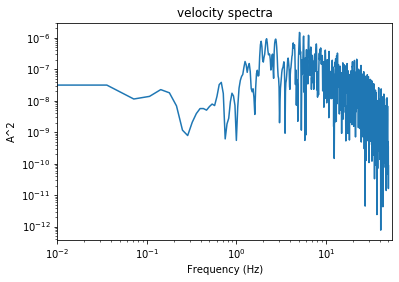

In [232]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(Pfreq,Pxx[0:Pnf])
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('A^2');
ax.set_title('velocity spectra');
ax.set_xlim(dt, 55)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

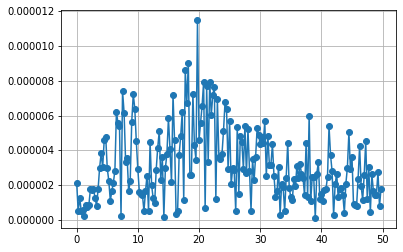

In [233]:
%matplotlib widget 
# Number of sample points
N = 400
# sample spacing
T = 1/sr

x = np.linspace(0.0, N*T, N, endpoint=False)
y = s.data[start:end+1000]

yf = rfft(y) #instead of fft as data type of y is real
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), marker='o') #what does this 2/N do???
plt.grid()
plt.show()

In [234]:
from earthquake import earthquake
c = cat_with_data.copy()
c.clear()
c.extend([cat_with_data[0]])
eq = earthquake(eq_name, c, data, picks, sensor_types = [])
eq.calc_Tpmax()
eq.calc_Tc()
print(eq._cached_params["tau_p_max"])
print(eq._cached_params["tau_c"])

[0.51824193060651014, 0.43754426732941737, 0.40169859170252536]
[0.2682018971852354, 0.1908354211956681, 0.31900362525925935]


## on displacement

In [235]:
with open(root+eq_name+'/picks.pkl', 'rb') as f:
    picks = pickle.load(f)
sr = data[0].stats.sampling_rate
tr_name = data[0].stats.network+'.'+data[0].stats.station+'.'+data[0].stats.location
pick = UTCDateTime(picks[tr_name])
start = int((pick - data[0].stats.starttime)*sr)
end = int(start + 4 * sr)
d = data[0].copy()#.filter('lowpass', freq=3)
d.integrate()

CX.HMBCX..HHE | 2019-01-31T19:44:44.679999Z - 2019-01-31T19:54:50.669999Z | 100.0 Hz, 60600 samples

detrend

In [240]:
coda = signal.detrend(d)
coda = d[start:end+4000]

taper and pad with zeros

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

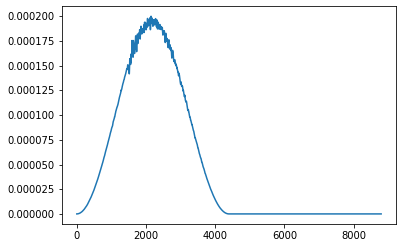

In [241]:
nx      = len(coda)
hann    = np.hanning(nx) #Is this the right sort of filter?
nx2     = 2*nx
x       = np.zeros(nx2)

x[0:nx] = coda*hann
plt.plot(x)

smooth

In [242]:
s.stats

         network: CX
         station: HMBCX
        location: 
         channel: HHE
       starttime: 2019-01-31T19:44:44.679999Z
         endtime: 2019-01-31T19:54:50.669999Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 60600
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 176, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 90112})
      processing: ["ObsPy 1.2.2: remove_response(fig=None::inventory=<obspy.core.inventory.inventory.Inventory object at 0x7fc46ecea390>::output='VEL'::plot=False::pre_filt=None::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)"]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.01, 55)

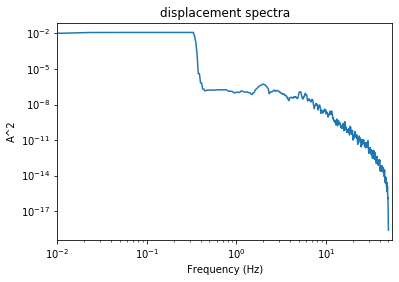

In [243]:
ft_x  = scipy.fft.fft(x,nx2)
Pxx   = abs(ft_x)**2
dt = s.stats.delta

Pfreq  = scipy.fft.rfftfreq(nx2,dt)#getting the frequencies to plot on the xaxis 
Pnf    = len(Pfreq)

nsmooth = 30
Pxx_smooth = np.convolve(Pxx, np.ones(nsmooth)/nsmooth)
#Because of the variance of spectral estimates, smoothing is necesary. We do this using a running window convolution. 
#It is a rough way to do it, you can choose better ways.


fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(Pfreq,Pxx_smooth[0:Pnf])
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('A^2');
ax.set_title('displacement spectra');
ax.set_xlim(dt, 55)

multitaper from alice

(2048,)


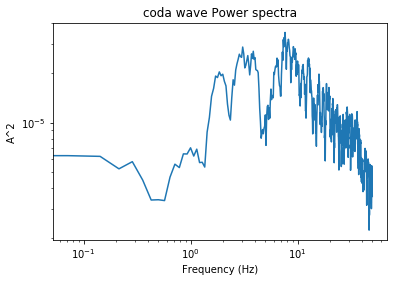

In [259]:
%matplotlib inline 
from spectrum import *
from pylab import *

#creating the frequencies to plot on x axis 
Pfreq  = scipy.fft.rfftfreq(len(coda),dt)

#doing the multitaper to get the spectra 
N = len(coda)
NW=4.5
k=5
[tapers, eigen] = dpss(N, NW, k)
Sk_complex, weights, eigenvalues=pmtm(coda, e=eigen, v=tapers, show=False)
Sk = abs(Sk_complex)
Sk = np.mean(Sk,axis =0)
Sk_sdv = np.std(Sk,axis =0)


#plotting the spectra in loglog
plt.loglog(Pfreq[:-1],Sk[0:N//2])
#plt.fill_between(Pfreq[:-1],(Sk+Sk_sdv)[0:N//2],(Sk-Sk_sdv)[0:N//2],alpha=0.2)
plt.xlabel('Frequency (Hz)');
plt.ylabel('A^2');
plt.title('coda wave Power spectra');

Pfreq_MHZ = Pfreq
Sk_MHZ = Sk 

print(Sk_MHZ.shape)
plt.show()